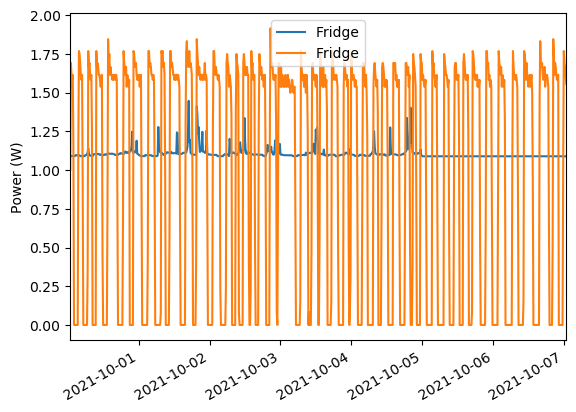

In [2]:
from nilmtk import DataSet 

test = DataSet(r'\Users\micki\nilmtk_test\data\converted_v12.h5')
test_elec = test.buildings[1].elec

result = DataSet('disag-outSEL_v02.h5')
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
plt.show()

In [3]:
test_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='SEL', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='SEL', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=3, building=1, dataset='SEL', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='SEL', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=5, building=1, dataset='SEL', appliances=[Appliance(type='stove', instance=1)])
)

In [4]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

C:\Users\micki\nilmtk_test\GRU\metrics.py:77: RuntimeWarning: invalid value encountered in true_divide
  return tp/float(tp+fp)


============ Recall: 0.0
============ Precision: nan
============ Accuracy: 0.016664985672973424
============ F1 Score: nan
============ Relative error in total energy: 0.9855799715671292
============ Mean absolute error(in Watts): 1.101451422897908


In [8]:
from nilmtk.electric import align_two_meters
import numpy as np

tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
tp

NameError: name 'states_pred' is not defined

In [9]:
from nilmtk.electric import align_two_meters
import numpy as np

def tp_tn_fp_fn(states_pred, states_ground):
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

In [11]:
tp_tn_fp_fn(predicted, ground_truth)

(0, 0, 0, 0)

In [12]:
from nilmtk.electric import align_two_meters
import numpy as np

def tp_tn_fp_fn(states_pred, states_ground):
    tp = np.sum(np.logical_and(states_pred == 1, states_ground == 1))
    fp = np.sum(np.logical_and(states_pred == 1, states_ground == 0))
    fn = np.sum(np.logical_and(states_pred == 0, states_ground == 1))
    tn = np.sum(np.logical_and(states_pred == 0, states_ground == 0))
    return tp, tn, fp, fn

def recall_precision_accuracy_f1(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    threshold = ground.on_power_threshold()
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        sum_samples += len(chunk)
        pr = np.array([0 if (p)<threshold else 1 for p in chunk.iloc[:,0]])
        gr = np.array([0 if p<threshold else 1 for p in chunk.iloc[:,1]])

        tp, tn, fp, fn = tp_tn_fp_fn(pr,gr)
        p = sum(pr)
        n = len(pr) - p

        chunk_results.append([tp,tn,fp,fn,p,n])

    if sum_samples == 0:
        return None
    else:
        [tp,tn,fp,fn,p,n] = np.sum(chunk_results, axis=0)

        res_recall = recall(tp,fn)
        res_precision = precision(tp,fp)
        res_f1 = f1(res_precision,res_recall)
        res_accuracy = accuracy(tp,tn,p,n)

        return (res_recall,res_precision,res_accuracy,res_f1)

def relative_error_total_energy(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    chunk_results = []
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        E_pred = sum(chunk.iloc[:,0])
        E_ground = sum(chunk.iloc[:,1])

        chunk_results.append([
                            E_pred,
                            E_ground
                            ])
    if sum_samples == 0:
        return None
    else:
        [E_pred, E_ground] = np.sum(chunk_results,axis=0)
        return abs(E_pred - E_ground) / float(max(E_pred,E_ground))

def mean_absolute_error(pred, ground):
    aligned_meters = align_two_meters(pred, ground)
    total_sum = 0.0
    sum_samples = 0.0
    for chunk in aligned_meters:
        chunk.fillna(0, inplace=True)
        sum_samples += len(chunk)
        total_sum += sum(abs((chunk.iloc[:,0]) - chunk.iloc[:,1]))
    if sum_samples == 0:
        return None
    else:
        return total_sum / sum_samples


def recall(tp,fn):
    return tp/float(tp+fn)

def precision(tp,fp):
    return tp/float(tp+fp)

def f1(prec,rec):
    return 2 * (prec*rec) / float(prec+rec)

def accuracy(tp, tn, p, n):
    return (tp + tn) / float(p + n)

In [13]:
tp

NameError: name 'tp' is not defined